# Product Sentiment Analysis Classification


In this notebook we will be doing sentiment classification in python using Classical ML techniques:
1. LOGISTIC REGRESSION (Implemented)
2. LSTM(To be Done)
3. LLM(To be Done)

# Step 0. Read in Data

In [12]:
def prepare_data(file_location):
    import warnings
    warnings.filterwarnings('ignore')
    import pandas as pd 
    print("\n----Inside prepare_data Stage----\n")
    # Load in dataset
    column_names = ['Review_UID', 'Product', 'Sentiment', 'Review']
    df = pd.read_csv(file_location,header=None,names=column_names)
    print("Raw Dataset info:")
    print(df.shape)
    df.info()
    df = df.dropna()
    print("\n----Dataset after dropping null info:----\n")
    print(df.shape)
    df.info()
    print("\n----End of prepare_data Stage----\n")
    return df


## Quick EDA

In [2]:
def quick_eda(df):
    import matplotlib.pyplot as plt
    plt.style.use('ggplot')
    print("\n----Inside EDA Stage----\n")
    print("Plotting count of reviewy by product")
    ax = df['Product'].value_counts().sort_index() \
        .plot(kind='bar',
            title='Count of Reviews by Products',
            figsize=(10, 5))
    ax.set_xlabel('Review Products')
    plt.show()
    
    print("Plotting count of reviewy by product")
    scores = df['Sentiment'].value_counts()
    plt.pie(df['Sentiment'].value_counts(), 
            labels=scores.index, 
            autopct='%1.1f%%', 
            radius=2, 
            colors=['#3bccff','#ff3333', '#ffd400','#014421'])
    plt.show()
    print("\n----End of eda Stage----\n")

# Step 1. Data Cleaning

#### Helper Functions

In [15]:
#This function converts to lower-case, removes square bracket, removes numbers and punctuation
def text_normalize_basic(text):
    import re
    import string
    from nltk.corpus import stopwords
    stopwords = set(stopwords.words('english'))
    #Basics
    text = text.lower() # transform text to lowercase
    text = re.sub(r'\[.*?\]', '', text) # remove '[]' and words in it
    text = re.sub(r'https?://\S+|www\.\S+', '', text) # remove links
    text = re.sub(r'<.*?>+', '', text) # remove '<>' and words in it
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)  #remove punctuation
    text = re.sub(r'[‘’“”…]', '', text) # remove "" and words in it
    text = re.sub(r'\n', '', text) # remove line feeds
    text = re.sub(r'\w*\d\w*', '', text) # remove numbers and words with numbers
    # Remove Stopwords
    text = [word for word in text.split(' ') if word not in stopwords] # remove stopwords
    text=" ".join(text) # put words back together to form a text
    return text
def text_normalize_stemming(text):
    import nltk
    stemmer = nltk.SnowballStemmer('english')
    #stemmer = nltk.porter.PorterStemmer()
    text = [stemmer.stem(word) for word in text.split(' ')] # stem the text
    text=" ".join(text) # put words back together to form a text
    return text
def text_normalize_emoji(text):
    import emoji
    # Custom processing
    text= emoji.demojize(text, delimiters=("", ""))
    return text
def text_normalize_lemmmatize(text):
    from nltk.stem import WordNetLemmatizer
    # Intilize Lemmatizer
    wordnet_lemmatizer = WordNetLemmatizer()
    #Lemmatization
    # Apply 
    text = " ".join([wordnet_lemmatizer.lemmatize(word , pos='v') for word in text.split(' ')])
    return text


def data_normalization(df):    
    
    import pandas as pd
    import numpy as np
    import nltk

    nltk.download('stopwords')
    nltk.download('wordnet')

    cleaned = lambda x: text_normalize_basic(x)
    stemmed = lambda x: text_normalize_stemming(x)
    emojised = lambda x: text_normalize_emoji(x)
    lemmatized = lambda x: text_normalize_lemmmatize(x)
    
    # Apply Normalization
    df['cleaned_review'] = pd.DataFrame(df.Review.apply(cleaned))
    df['cleaned_review']  = df['cleaned_review'].apply(lambda x: " ".join(x.split()) if isinstance(x, str) else x)
    
    print("\n----Dataset after cleaning info:----\n")
    print("Cleaned Dataset info:")
    print(df.shape)
    df.info()
    
    print("\n----Removing null or spaces in Dataset after cleaning info:----\n")
    df = df.replace(r'^\s*$',float('NaN'),regex=True)
    #df['cleaned_review'].replace(" ", np.nan, inplace=True)
    df.dropna(inplace=True)
    print("\n----Cleaned Dataset after dropping null info:----\n")
    print(df.shape)
    df.info()
    
    df['stemmed_review'] = pd.DataFrame(df.cleaned_review.apply(stemmed))
    print("\n----Removing null or spaces in Dataset after stemming info:----\n")
    df['stemmed_review'].replace(" ", np.nan, inplace=True)
    df.dropna(subset=['stemmed_review'], inplace=True)
    print("\n----Cleaned Dataset after dropping null info:----\n")
    print(df.shape)
    
    df['lemmatized_review'] = pd.DataFrame(df.stemmed_review.apply(lemmatized))
    print("\n----Removing null or spaces in Dataset after lemmatizing info:----\n")
    df['lemmatized_review'].replace(" ", np.nan, inplace=True)
    df.dropna(subset=['lemmatized_review'], inplace=True)
    print("\n----Cleaned Dataset after dropping null info:----\n")
    print(df.shape)
    df['emojised_review'] = pd.DataFrame(df.lemmatized_review.apply(emojised))
    
    # Let's take a look at the updated text

    df_processed = df[["Review_UID","Product","Sentiment","Review","cleaned_review","stemmed_review","lemmatized_review","emojised_review"]]
    print("The processed dataset created is :")
    print(df_processed.head(5))
    return df_processed

In [4]:
def preprocess_data(df):
    
    import pandas as pd
    
    print("\n----Inside preprocess_data Stage----\n")
    
    ### Checking Missing values in the Data Set and printing the Percentage for Missing Values for Each Columns ###

    count = df.isnull().sum().sort_values(ascending=False)
    percentage = ((df.isnull().sum()/len(df)*100)).sort_values(ascending=False)
    missing_data = pd.concat([count, percentage], axis=1,
    keys=['Count','Percentage'])

    print('Count and percentage of missing values for the columns:')
    missing_data
    print('Dataset info before dropna:')
    print(df.shape)
    df.info()
    
    #Drop Rows with null columns
    df.dropna(subset=['Review'], inplace=True)
    # reset index just to be safe
    df.reset_index(drop=True, inplace=True)
    print('Dataset info after dropna:')
    print(df.shape)
    df.info()
    
    df = df.drop_duplicates()
    print('Dataset info after drop duplicate:')
    print(df.shape)
    df.info()
    
    print("---\nRunning Normalization on the Dataset...../n ")
    df = data_normalization(df)
   
    #Drop Rows with null columns
    df = df.dropna()
    # reset index just to be safe
    df = df.reset_index(drop=True)
    print('Normalized Dataset info after dropna:')
    print(df.shape)
    df.info()
    df.to_csv('../data/processed/training.csv')
    print("\n----End of preprocess_data Stage----\n")
    return df

# Main


----Inside prepare_data Stage----

Raw Dataset info:
(74682, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Review_UID  74682 non-null  int64 
 1   Product     74682 non-null  object
 2   Sentiment   74682 non-null  object
 3   Review      73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB

----Dataset after dropping null info:----

(73996, 4)
<class 'pandas.core.frame.DataFrame'>
Index: 73996 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Review_UID  73996 non-null  int64 
 1   Product     73996 non-null  object
 2   Sentiment   73996 non-null  object
 3   Review      73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.8+ MB

----End of prepare_data Stage----


----Inside EDA Stage----

Plotting count of reviewy 

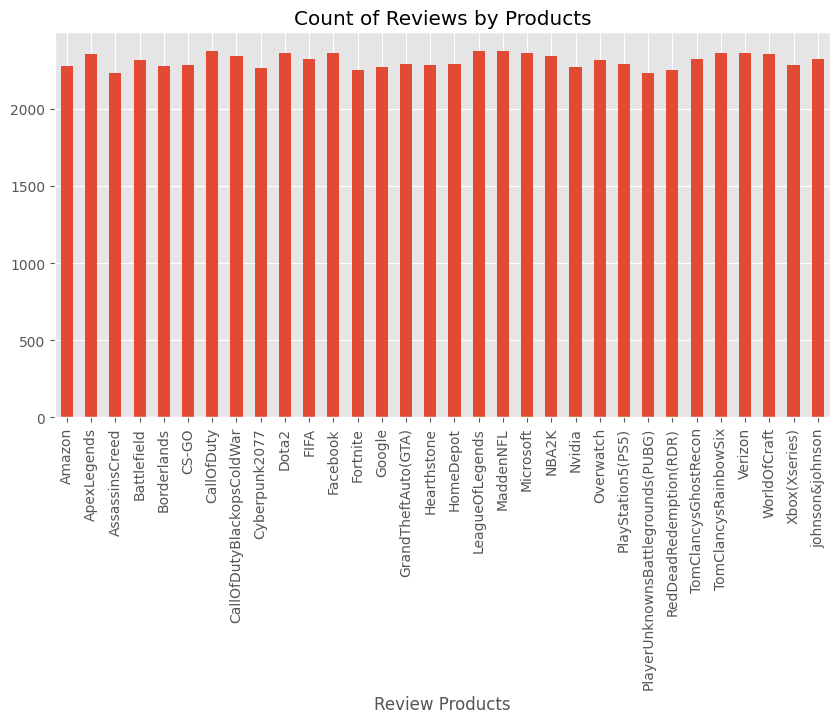

Plotting count of reviewy by product


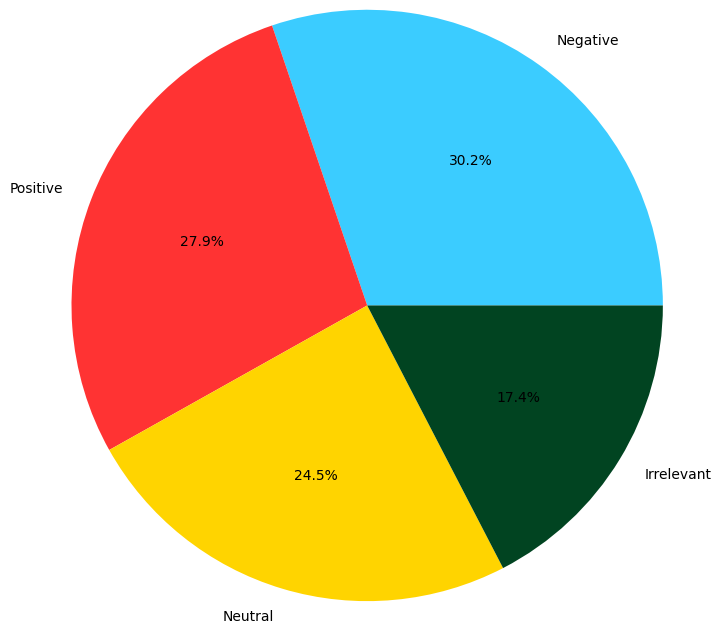


----End of eda Stage----


----Inside preprocess_data Stage----

Count and percentage of missing values for the columns:
Dataset info before dropna:
(73996, 4)
<class 'pandas.core.frame.DataFrame'>
Index: 73996 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Review_UID  73996 non-null  int64 
 1   Product     73996 non-null  object
 2   Sentiment   73996 non-null  object
 3   Review      73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.8+ MB
Dataset info after dropna:
(73996, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73996 entries, 0 to 73995
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Review_UID  73996 non-null  int64 
 1   Product     73996 non-null  object
 2   Sentiment   73996 non-null  object
 3   Review      73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB
Dataset in

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vikra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vikra\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



----Dataset after cleaning info:----

Cleaned Dataset info:
(71656, 5)
<class 'pandas.core.frame.DataFrame'>
Index: 71656 entries, 0 to 73995
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Review_UID      71656 non-null  int64 
 1   Product         71656 non-null  object
 2   Sentiment       71656 non-null  object
 3   Review          71656 non-null  object
 4   cleaned_review  71656 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.3+ MB

----Removing null or spaces in Dataset after cleaning info:----


----Cleaned Dataset after dropping null info:----

(69840, 5)
<class 'pandas.core.frame.DataFrame'>
Index: 69840 entries, 0 to 73995
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Review_UID      69840 non-null  int64 
 1   Product         69840 non-null  object
 2   Sentiment       69840 non-null  object
 3   Review    

In [27]:
loaeded_dataset=prepare_data('../data/raw/training.csv')

quick_eda(loaeded_dataset)
processed_data=preprocess_data(loaeded_dataset)
df=processed_data


#####
#example = ["The professional dota 2 scene is fucking exploding and I completely welcome it."]
#result = model.predict(example)

#print(result)

# Model Training

In [19]:
from sklearn.model_selection import train_test_split

Independent_var = df.cleaned_review #emojised_review cleaned_review
Dependent_var = df.Sentiment

IV_train, IV_test, DV_train, DV_test = train_test_split(Independent_var, Dependent_var, test_size = 0.2, random_state = 225)

print('IV_train :', len(IV_train))
print('IV_test  :', len(IV_test))
print('DV_train :', len(DV_train))
print('DV_test  :', len(DV_test))

IV_train.to_csv(f'../data/interim/X_train.csv', index=False)
IV_test.to_csv(f'../data/interim/X_test.csv', index=False)
DV_train.to_csv(f'../data/interim/y_train.csv', index=False)
DV_test.to_csv(f'../data/interim/y_test.csv', index=False)

IV_train : 55872
IV_test  : 13968
DV_train : 55872
DV_test  : 13968


In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

tvec = TfidfVectorizer()
clf2 = LogisticRegression(solver = "lbfgs")


from sklearn.pipeline import Pipeline

In [22]:
model = Pipeline([('vectorizer',tvec),('classifier',clf2)])

model.fit(IV_train, DV_train)

import pickle
with open(f'../data/external/model.pkl', 'wb') as f:
    pickle.dump(model, f)

print("\n logistic regression classifier is trained on sentiment data and saved to PV location ../external/model.pkl ----")

from sklearn.metrics import confusion_matrix

predictions = model.predict(IV_test)

confusion_matrix(predictions, DV_test)


 logistic regression classifier is trained on sentiment data and saved to PV location ../external/model.pkl ----


array([[1670,  124,  130,  123],
       [ 279, 3528,  396,  318],
       [ 229,  240, 2552,  306],
       [ 309,  295,  343, 3126]], dtype=int64)

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

print("Accuracy : ", accuracy_score(predictions, DV_test))
print("Precision : ", precision_score(predictions, DV_test, average = 'weighted'))
print("Recall : ", recall_score(predictions, DV_test, average = 'weighted'))

Accuracy :  0.7786368843069874
Precision :  0.7841693720187305
Recall :  0.7786368843069874


In [24]:
example = ["The professional dota 2 scene is fucking exploding and I completely welcome it."]
result = model.predict(example)

print(result)

['Positive']


# Model Validation

In [17]:
validation_dataset=prepare_data('../data/raw/validation.csv')


----Inside prepare_data Stage----

Raw Dataset info:
(1000, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Review_UID  1000 non-null   int64 
 1   Product     1000 non-null   object
 2   Sentiment   1000 non-null   object
 3   Review      1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 31.4+ KB

----Dataset after dropping null info:----

(1000, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Review_UID  1000 non-null   int64 
 1   Product     1000 non-null   object
 2   Sentiment   1000 non-null   object
 3   Review      1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 31.4+ KB

----End of prepare_data Stage----



In [18]:
import pandas as pd
cleaned_text= lambda x: text_normalize_basic(x)
   
# Apply Normalization
validation_dataset['cleaned_review'] = pd.DataFrame(validation_dataset.Review.apply(cleaned_text))



In [19]:
validation_dataset_X = validation_dataset['cleaned_review']
validation_dataset_y = validation_dataset['Sentiment']

validation_dataset_X.to_csv(f'../data/interim/X_valid.csv', index=False)
validation_dataset_y.to_csv(f'../data/interim/y_valid.csv', index=False)

In [45]:
predictions = model.predict(validation_dataset_X)

In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

print("Accuracy : ", accuracy_score(predictions, validation_dataset_y))
print("Precision : ", precision_score(predictions, validation_dataset_y, average = 'weighted'))
print("Recall : ", recall_score(predictions, validation_dataset_y, average = 'weighted'))

Accuracy :  0.871
Precision :  0.8752649478094532
Recall :  0.871


In [50]:
import numpy as np
import pandas as pd
import pickle
print("----Inside predict_test_data stage ----")
with open(f'../data/external/model.pkl', 'rb') as f:
    model = pickle.load(f)

IV_test= pd.read_csv('../data/interim/X_valid.csv',index_col=False)
DV_test= pd.read_csv('../data/interim/y_valid.csv',index_col=False)
predictions = model.predict(IV_test)
np.save(f'../data/external/y_pred.npy', predictions)

df_predictions = pd.DataFrame(predictions)
df_predictions.to_csv('../data/external/y_pred.csv')

----Inside predict_test_data stage ----


In [56]:

IV_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   cleaned_review  999 non-null    object
dtypes: object(1)
memory usage: 7.9+ KB


In [38]:
validation_dataset.head()

,Review_UID,Product,Sentiment,Review,cleaned_review
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...,mentioned facebook struggling motivation go ru...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...,bbc news amazon boss jeff bezos rejects claim...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...,microsoft pay word functions poorly samsungus ...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,...",csgo matchmaking full closet hacking truly awf...
4,4433,Google,Neutral,Now the President is slapping Americans in the...,president slapping americans face really commi...


In [27]:
validation_dataset_X.info()
validation_dataset_X

<class 'pandas.core.series.Series'>
RangeIndex: 1000 entries, 0 to 999
Series name: cleaned_review
Non-Null Count  Dtype 
--------------  ----- 
1000 non-null   object
dtypes: object(1)
memory usage: 7.9+ KB


0      mentioned facebook struggling motivation go ru...
1      bbc news  amazon boss jeff bezos rejects claim...
2      microsoft pay word functions poorly samsungus ...
3      csgo matchmaking full closet hacking truly awf...
4      president slapping americans face really commi...
                             ...                        
995    ⭐️ toronto arts culture capital canada wonder ...
996    actually good move tot bring viewersi one peop...
997    today sucked time drink wine n play borderland...
998           bought fraction microsoft today small wins
999    johnson  johnson stop selling talc baby powder...
Name: cleaned_review, Length: 1000, dtype: object